In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
from scipy import stats
from sklearn.preprocessing import normalize
from scipy.stats import kstest, chisquare # tests
from scipy.stats import gamma, beta, norm, lognorm # distributions
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls "/content/drive/MyDrive/MDALabs/lab1/data/train_timeseries/"
%ls "/content/drive/MyDrive/MDALabs/lab3/BAMTmaster/"

train_timeseries.csv
bayesian/        data/         external/  img/         requirements.txt
block_learning/  example/      fedot/     preprocess/  visualization/
core/            experiments/  graph/     Readme.md


bold text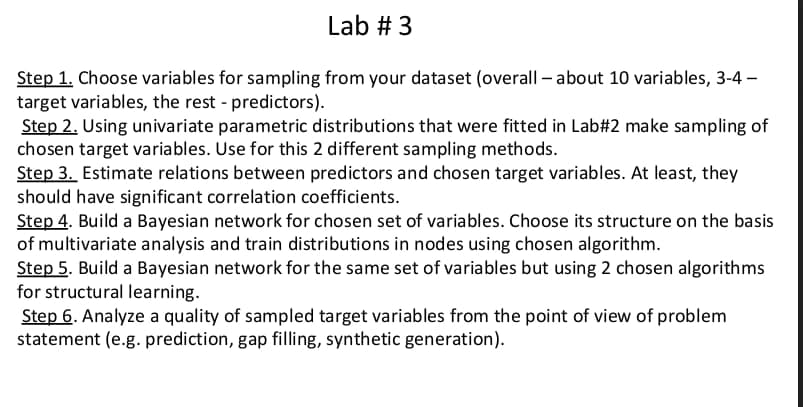

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MDALabs/lab1/data/train_timeseries/train_timeseries.csv").sample(100_000)
#data = pd.read_csv("/content/drive/MyDrive/train_timeseries-002.csv")
test = pd.read_csv("/content/drive/MyDrive/MDALabs/lab1/data/test_timeseries/test_timeseries.csv").sample(100_000)

In [ ]:
def delete_extreme_p(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    under_border, top_border = q1 - 1.5*iqr, q3 + 1.5*iqr
    data = data[data > under_border]
    data = data[data < top_border]
    return data

In [ ]:
chosen_columns = ['PRECTOT', 'PS', 'T2MDEW', 'T2M_RANGE', 'WS10M', 'T2M', 'QV2M', 'T2MWET', 'TS']

# **STEP 1**

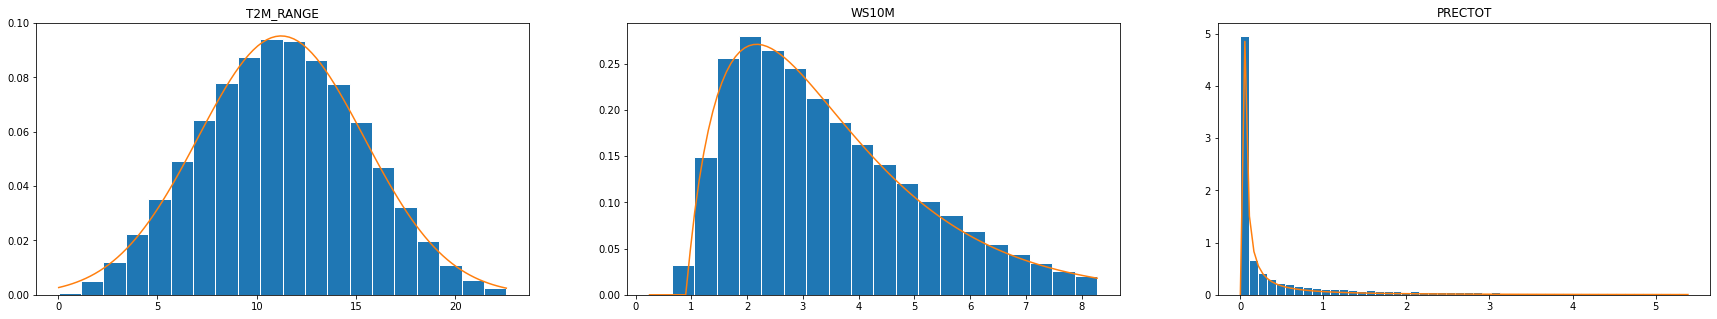

In [ ]:
target_features = ['T2M_RANGE', 'WS10M', 'PRECTOT']
predictor_features = ['PS', 'T2MDEW', 'T2M', 'QV2M', 'T2MWET', 'TS']

parameters = {'PRECTOT': {'beta': [0.5637421312099691, 12.206755635597045],
  'gamma': [0.9001402600482455, 0.05389999997122874, 2.317439537590622],
  'lognorm': [2.9040409072143323, 0.02620940533491877, 0.022948832852127104],
  'norm': [0.016918149499874344, 0.07006859173924922]},
 'T2MDEW': {'beta': [1.6226994470089335, 0.030758475344946475],
  'gamma': [0.07830811804819221, 0.40780104111719384, 1.7708014775091594],
  'lognorm': [2.5215596390685073, 0.4078011867421177, 0.030305230877783917],
  'norm': [8.284613339026278, 11.809327202515721]},
 'T2M_RANGE': {'beta': [2.3682972818329837, 0.00038053173582434696],
  'gamma': [0.0068528634972802194, 0.716426588090602, 2.3366114388948334],
  'lognorm': [7.011382123650852, 1.211717669971204, 4.917863769921563e-05],
  'norm': [11.224126370195242, 4.187016284192087]},
 'WS10M': {'beta': [0.0025047547459192817, 0.0039304756900820255],
  'gamma': [1.8799118648867053, 0.9124603808896647, 1.431332707619562],
  'lognorm': [0.6533936743918839, 0.410140640072043, 2.7227891964194844],
  'norm': [2.8970639269852647, 1.5838617183433013]}}

dof = 100

plt.figure(figsize=(30,5))
col = 'T2M_RANGE'

norm_rv = stats.norm(*parameters[col]['norm'])

x = np.linspace(delete_extreme_p(data[col]).min(), delete_extreme_p(data[col]).max(), dof)
y = norm_rv.pdf(x)

plt.subplot(131)
plt.title(col)
plt.hist(delete_extreme_p(data[col]), bins=20 , density=True, edgecolor='w')
plt.plot(x, y)
#-------------------------------------------------
col = 'WS10M'

norm_rv = stats.gamma(*parameters[col]['gamma'])

x = np.linspace(delete_extreme_p(data[col]).min(), delete_extreme_p(data[col]).max(), dof)
y = norm_rv.pdf(x)

plt.subplot(132)
plt.title(col)
plt.hist(delete_extreme_p(data[col]), bins=20 , density=True, edgecolor='w')
plt.plot(x, y)
#-------------------------------------------------
col = 'PRECTOT'

norm_rv = stats.lognorm(*parameters[col]['lognorm'])

x = np.linspace(delete_extreme_p(data[col]).min(), delete_extreme_p(data[col]).max(), dof)
y = norm_rv.pdf(x)

plt.subplot(133)
plt.title(col)
plt.hist(delete_extreme_p(data[col]), bins=50 , density=True, edgecolor='w')
plt.plot(x, y)
plt.show()


# **STEP 2**
## **Accept - Reject Sampling**


In [ ]:
new_samples = {}

In [ ]:
def sampler(f, g, c, min_max, N=1_000_000):
  min_, max_ = min_max
  X = np.random.random(N) * (max_ - min_) + min_
  u = np.random.uniform(0, c * g(X))

  samples = X[u <= f(X)]
  print("Accepted - %.2f" % (len(samples) / N))
  return samples

### T2M_RANGE

Для метода Accept - Reject Sampling будем использовать функцию g(x) как функцию плотности вероятности Uniform распределения

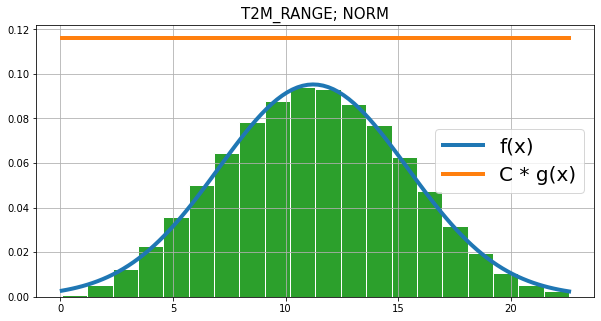

Больше ли g(x) всех точек f(x) при C = 4?:  True


In [ ]:
FEATURE = 'T2M_RANGE'

dof = 100
x = np.linspace(delete_extreme_p(data[FEATURE]).min(), delete_extreme_p(data[FEATURE]).max(), dof)

f = stats.norm(*parameters[FEATURE]['norm']).pdf
#g = stats.norm(loc=data[FEATURE].mean(), scale=5).pdf
g = stats.uniform(loc=data[FEATURE].min(), scale=data[FEATURE].max()).pdf
C = 4

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; NORM', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.hist(delete_extreme_p(data[FEATURE]), bins=20 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.grid()
plt.show()
print(f'Больше ли g(x) всех точек f(x) при C = {C}?: ', np.all(C * g(x) > f(x)))

Accepted - 0.38


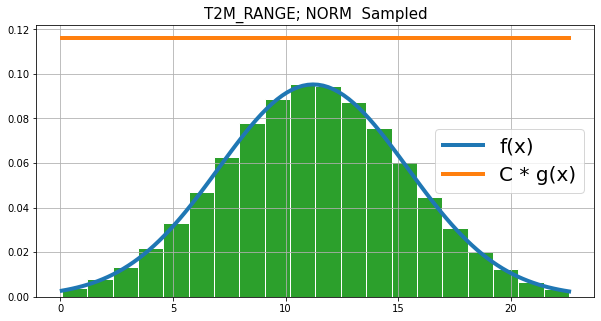

In [ ]:
samples_T2M_RANGE = sampler(f, g, C, min_max=(min(x), max(x)))

new_samples[FEATURE + 'ars'] = samples_T2M_RANGE

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; NORM  Sampled', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.hist(samples_T2M_RANGE, bins=20 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.grid()
plt.show()

### WS10M

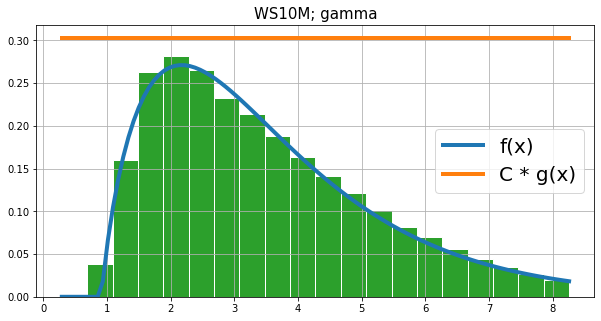

Больше ли g(x) всех точек f(x) при C = 6.5?:  True


In [ ]:
FEATURE = 'WS10M'

dof = 100
x = np.linspace(delete_extreme_p(data[FEATURE]).min(), delete_extreme_p(data[FEATURE]).max(), dof)

f = stats.gamma(*parameters[FEATURE]['gamma']).pdf
#g = stats.norm(loc=data[FEATURE].mean(), scale=5).pdf
g = stats.uniform(loc=data[FEATURE].min(), scale=data[FEATURE].max()).pdf
C = 6.5

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; gamma', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.grid()
plt.hist(delete_extreme_p(data[FEATURE]), bins=20 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.show()
print(f'Больше ли g(x) всех точек f(x) при C = {C}?: ', np.all(C * g(x) > f(x)))

Accepted - 0.40


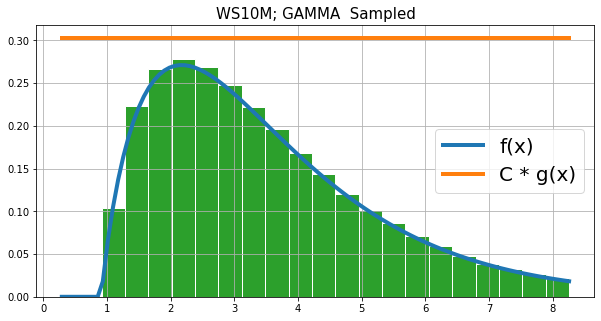

In [ ]:
samples_WS10M = sampler(f, g, C, min_max=(min(x), max(x)))

new_samples[FEATURE + 'ars'] = samples_WS10M

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; GAMMA  Sampled', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.hist(samples_WS10M, bins=20 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.grid()
plt.show()

### PRECTOT

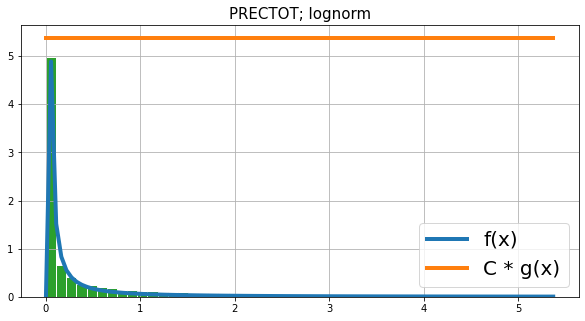

Больше ли g(x) всех точек f(x) при C = 1000?:  True


In [ ]:
FEATURE = 'PRECTOT'

dof = 100
x = np.linspace(delete_extreme_p(data[FEATURE]).min(), delete_extreme_p(data[FEATURE]).max(), dof)

f = stats.lognorm(*parameters[FEATURE]['lognorm']).pdf
#g = stats.norm(loc=data[FEATURE].mean(), scale=5).pdf
g = stats.uniform(loc=data[FEATURE].min(), scale=data[FEATURE].max()).pdf
C = 1000

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; lognorm', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.hist(delete_extreme_p(data[FEATURE]), bins=50 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.grid()
plt.show()
print(f'Больше ли g(x) всех точек f(x) при C = {C}?: ', np.all(C * g(x) > f(x)))

Accepted - 0.02


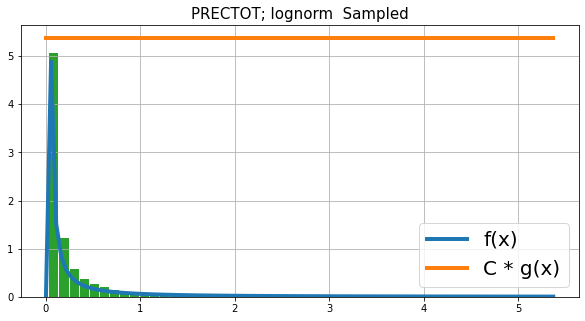

In [ ]:
samples_PRECTOT = sampler(f, g, C, min_max=(min(x), max(x)), N=1_000_000)

new_samples[FEATURE + 'ars'] = samples_PRECTOT

plt.figure(figsize=(10,5))
plt.title(FEATURE + '; lognorm  Sampled', fontsize=15)
plt.plot(x, f(x), lw=4, label='f(x)')
plt.plot(x, C * g(x), lw=4, label='C * g(x)')
plt.hist(samples_PRECTOT, bins=50 , density=True, edgecolor='w')
plt.legend(fontsize=20)
plt.grid()
plt.show()

## **Inverse transform sampling**

In [ ]:
def sampler_its(cdf, N = 1_000_000):
  R = np.random.uniform(0, 1, N)
  cum_prob = cdf
  gen_values = [float(values[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]
  return gen_values

### T2M_RANGE


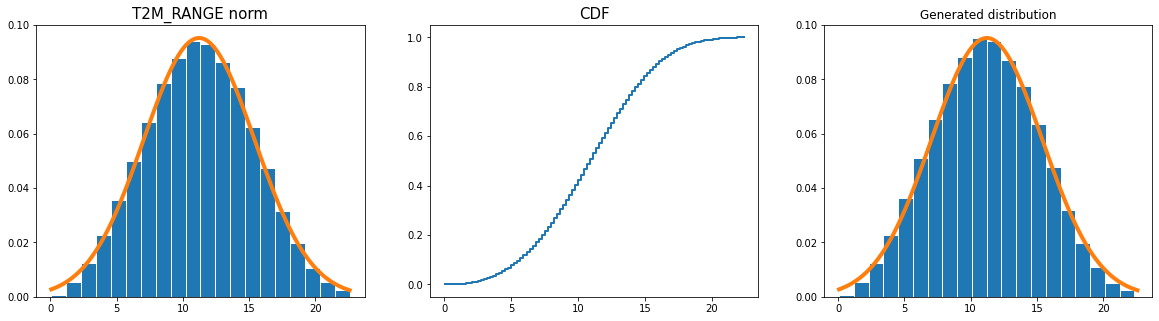

In [ ]:
FEATURE = 'T2M_RANGE'
info = delete_extreme_p(data[FEATURE]).values

dof = 100
x = np.linspace(min(info), max(info), dof)
pdf = stats.norm(*parameters[FEATURE]['norm']).pdf

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title(FEATURE + " norm", fontsize=15)
plt.hist(info, bins=20, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=4)

fluxes, values = np.histogram(info, bins=dof)
prob = fluxes / float(sum(fluxes))
cum_prob = np.cumsum(prob)

plt.subplot(132)
plt.title("CDF", fontsize=15)
plt.step(values[:-1], cum_prob, lw=2)

gen_values = sampler_its(cum_prob)

plt.subplot(133)
plt.title("Generated distribution")
plt.hist(gen_values, bins=20, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=4)

plt.show()

new_samples[FEATURE + 'its'] = gen_values

### WS10M

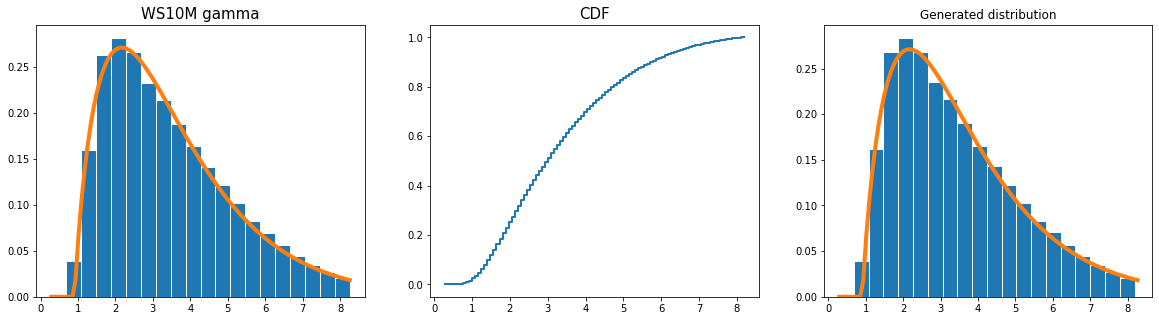

In [ ]:
FEATURE = 'WS10M'
info = delete_extreme_p(data[FEATURE]).values

dof = 100
x = np.linspace(min(info), max(info), dof)
pdf = stats.gamma(*parameters[FEATURE]['gamma']).pdf

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title(FEATURE + " gamma", fontsize=15)
plt.hist(info, bins=20, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=4)

fluxes, values = np.histogram(info, bins=dof)
prob = fluxes / float(sum(fluxes))
cum_prob = np.cumsum(prob)

plt.subplot(132)
plt.title("CDF", fontsize=15)
plt.step(values[:-1], cum_prob, lw=2)

gen_values = sampler_its(cum_prob)

plt.subplot(133)
plt.title("Generated distribution")
plt.hist(gen_values, bins=20, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=4)

plt.show()

new_samples[FEATURE + 'its'] = gen_values

### PRECTOT

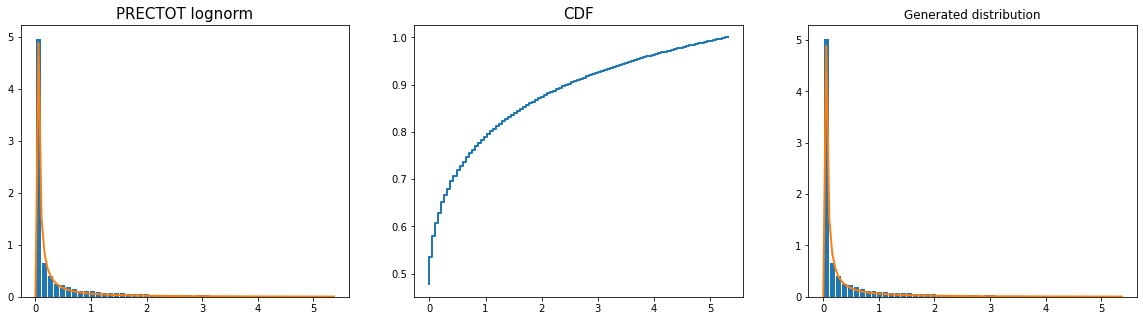

In [ ]:
FEATURE = 'PRECTOT'
info = delete_extreme_p(data[FEATURE]).values

dof = 100
x = np.linspace(min(info), max(info), dof)
pdf = stats.lognorm(*parameters[FEATURE]['lognorm']).pdf

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title(FEATURE + " lognorm", fontsize=15)
plt.hist(info, bins=50, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=2)

fluxes, values = np.histogram(info, bins=dof)
prob = fluxes / float(sum(fluxes))
cum_prob = np.cumsum(prob)

plt.subplot(132)
plt.title("CDF", fontsize=15)
plt.step(values[:-1], cum_prob, lw=2)

gen_values = sampler_its(cum_prob)

plt.subplot(133)
plt.title("Generated distribution")
plt.hist(gen_values, bins=50, edgecolor='w', density=True)
plt.plot(x, pdf(x), lw=2)

plt.show()

new_samples[FEATURE + 'its'] = gen_values

## **TESTS**

In [ ]:
def rmse(X, Y):
  assert len(X) == len(Y)
  return np.sqrt(np.sum( (X - Y)**2 )) / X.shape[0]

scores = [rmse(delete_extreme_p(data['PRECTOT']).sample(len(new_samples['PRECTOTars'])), new_samples['PRECTOTars']), 
          rmse(delete_extreme_p(data['PRECTOT']).sample(len(new_samples['PRECTOTits'])), new_samples['PRECTOTits'])]
print("RMSE PRECTOT : {:.4f} Accept - Reject Sampling  and {:.4f} Inverse transform sampling".format(*scores))

scores = [rmse(delete_extreme_p(data['WS10M']).sample(len(new_samples['WS10Mars'])), new_samples['WS10Mars']), 
          rmse(delete_extreme_p(data['WS10M']).sample(len(new_samples['WS10Mits'])), new_samples['WS10Mits'])]
print("RMSE WS10M : {:.4f} Accept - Reject Sampling  and {:.4f} Inverse transform sampling".format(*scores))

scores = [rmse(delete_extreme_p(data['T2M_RANGE']).sample(len(new_samples['T2M_RANGEars'])), new_samples['T2M_RANGEars']), 
          rmse(delete_extreme_p(data['T2M_RANGE']).sample(len(new_samples['T2M_RANGEits'])), new_samples['T2M_RANGEits'])]
print("RMSE T2M_RANGE : {:.4f} Accept - Reject Sampling  and {:.4f} Inverse transform sampling".format(*scores))

RMSE PRECTOT : 0.0100 Accept - Reject Sampling  and 0.0017 Inverse transform sampling
RMSE WS10M : 0.0036 Accept - Reject Sampling  and 0.0023 Inverse transform sampling
RMSE T2M_RANGE : 0.0092 Accept - Reject Sampling  and 0.0056 Inverse transform sampling


# **STEP 3**

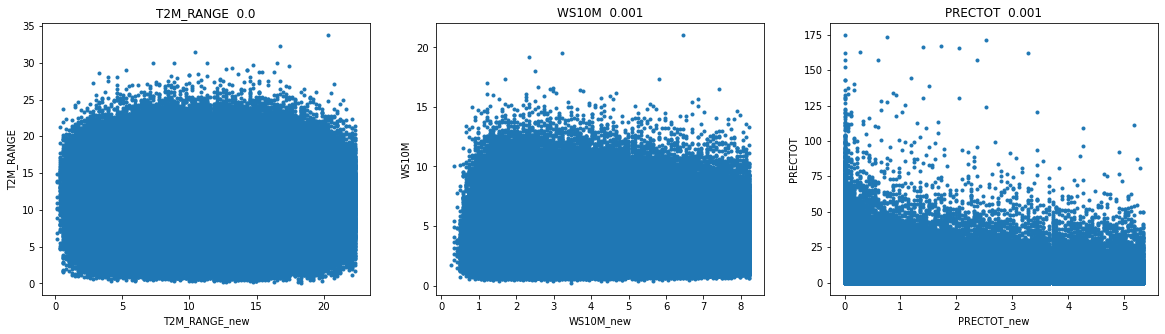

In [ ]:
length = len(target_features)

plt.figure(figsize=(20,5))
for i, target in enumerate(target_features):
  Y = (delete_extreme_p(data[target].values))
  X = (new_samples[target + '_new'].values)[ : len(Y)]
  plt.subplot(int('1' + str(length) + str(i + 1)))
  plt.title(target + '  ' + str(round(np.corrcoef(X, Y)[0, 1], 3)))
  plt.plot(new_samples[target + '_new'], data[target], '.')
  plt.xlabel(target + '_new')
  plt.ylabel(target)
plt.show()

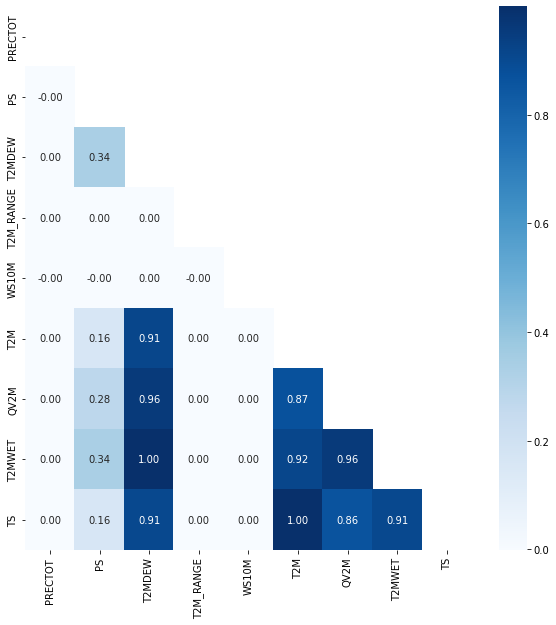

In [ ]:
data_ = data[chosen_columns].copy()
for target in target_features:
  data_[target] = (new_samples[target + '_new']).values


correlation_matrix = data_.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_matrix, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')
plt.show()

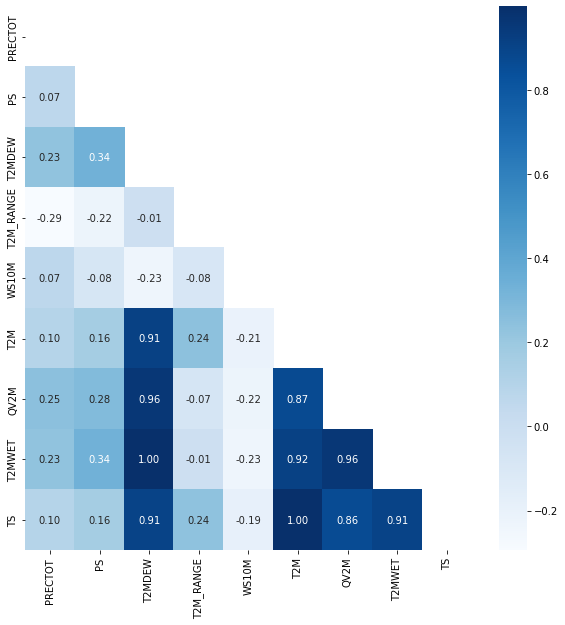

In [ ]:
dataset = data[chosen_columns]
correlation_matrix = dataset.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_matrix, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')
plt.show()

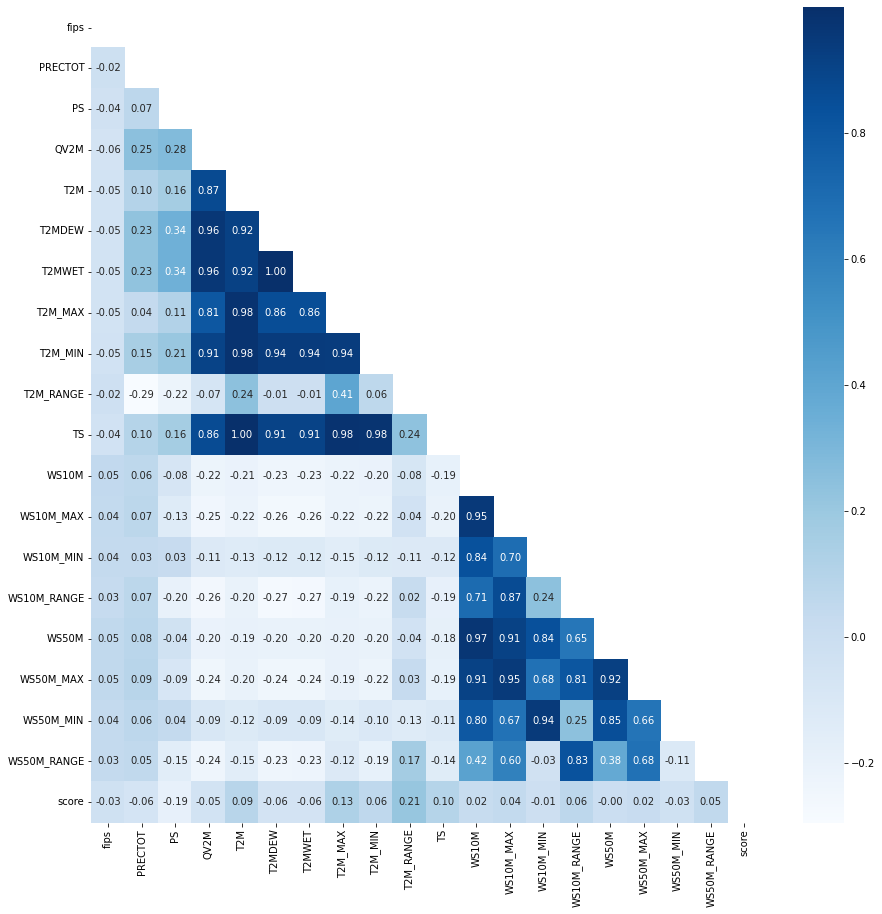

In [ ]:
correlation_matrix = data.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(correlation_matrix, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')
plt.show()

#**STEP 4**

In [ ]:
!pip install cloudpickle==2.0.0 backcall==0.2.0  colorama==0.4.4 cycler==0.10.0 deap==1.3.1 decorator==5.1.0 future==0.18.2 gmr==1.6.1 hyperopt==0.2.5 imageio==2.9.0 ipython==7.28.0 jedi==0.18.0 Jinja2==3.0.2 joblib==1.0.1 jsonpickle==2.0.0 kiwisolver==1.3.2 kmodes==0.11.0 MarkupSafe==2.0.1 matplotlib==3.4.3 matplotlib-inline==0.1.3 networkx==2.6.3 numpy==1.21.2 pandas==1.3.3 parso==0.8.2 patsy==0.5.2 pgmpy==0.1.16 pickleshare==0.7.5 Pillow==8.3.2 pomegranate==0.14.5 prompt-toolkit==3.0.20 Pygments==2.10.0 pyparsing==2.4.7 python-dateutil==2.8.2 pytz==2021.3 pyvis==0.1.9 PyYAML==5.4.1 scikit-learn==1.0 scipy==1.7.1 seaborn==0.11.2 six==1.16.0 sklearn==0.0 statsmodels==0.13.0 threadpoolctl==3.0.0 torch==1.9.1 tqdm==4.62.3 traitlets==5.1.0 typing-extensions==3.10.0.2 wcwidth==0.2.5 

     |████████████████████████████████| 160 kB 7.9 MB/s 
     |████████████████████████████████| 829 kB 49.0 MB/s 
     |████████████████████████████████| 248 kB 36.0 MB/s 
     |████████████████████████████████| 965 kB 34.3 MB/s 
     |████████████████████████████████| 3.3 MB 33.4 MB/s 
     |████████████████████████████████| 788 kB 48.8 MB/s 
     |████████████████████████████████| 1.4 MB 74.5 MB/s 
     |████████████████████████████████| 133 kB 59.5 MB/s 
     |████████████████████████████████| 303 kB 60.5 MB/s 
     |████████████████████████████████| 10.3 MB 44.3 MB/s 
     |████████████████████████████████| 15.7 MB 42.9 MB/s 
     |████████████████████████████████| 11.3 MB 22.1 MB/s 
     |████████████████████████████████| 1.9 MB 42.9 MB/s 
     |████████████████████████████████| 3.0 MB 25.7 MB/s 
     |████████████████████████████████| 17.9 MB 651 kB/s 
     |████████████████████████████████| 370 kB 45.7 MB/s 
     |████████████████████████████████| 1.0 MB 50.3 MB/s 
     |██████

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MDALabs/lab3/BAMTmaster/')

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc

In [ ]:
bn = {'V': ['PRECTOT', 'PS', 'T2MDEW', 'T2M_RANGE', 'WS10M', 'T2M', 'QV2M', 'T2MWET', 'TS'],
'E': [['PRECTOT', 'T2M_RANGE'], ['T2M_RANGE', 'T2M'], ['T2M', 'T2MDEW'], ['WS10M', 'T2MDEW'], ['WS10M', 'T2MWET'], ['T2MWET', 'QV2M'], ['T2MWET', 'T2MDEW'], ['TS', 'T2MWET'], ['TS', 'T2MDEW'], ['TS', 'QV2M'], ['TS', 'T2M'], ['PS', 'QV2M'], ['QV2M', 'T2M']]
}

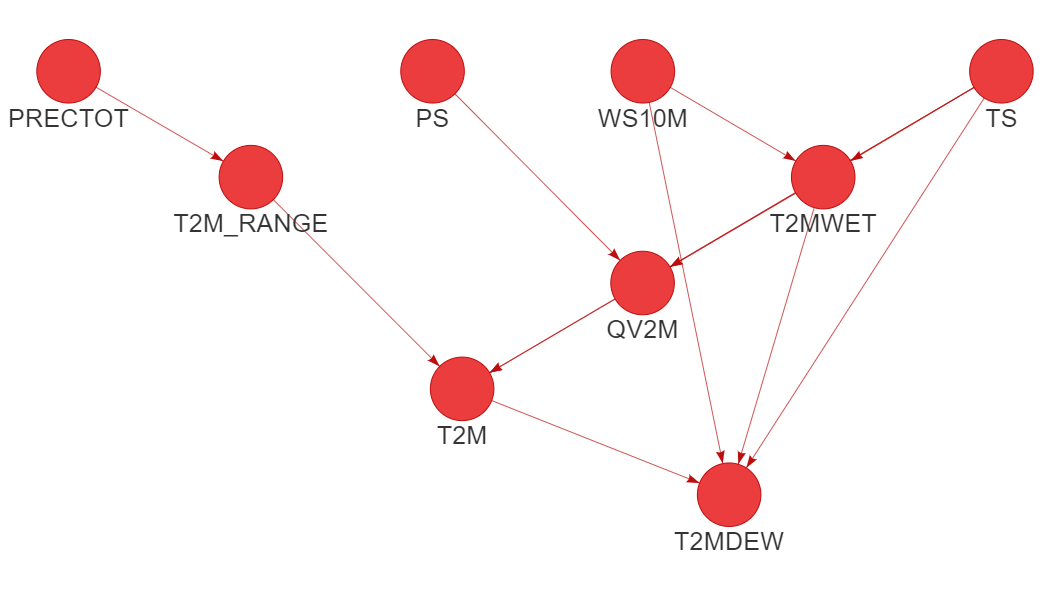

In [ ]:
params = parameter_learning(sample, nodes_type, bn, 'simple')

save_structure(bn, 'bn')
skel = read_structure('bn')

save_params(params, 'bn_param')
params = read_params('bn_param')

bn = HyBayesianNetwork(skel, params)

In [ ]:
synth_df = generate_synthetics(bn, nodes_sign, 'simple', 800)

In [ ]:
for feature in tqdm(target_features):
    sns.distplot(data[feature])
    sns.distplot(synth_df[feature])
    plt.show()

# **STEP 5**

In [ ]:
data_ = data[chosen_columns]

nodes_type = get_nodes_type(data_)
print(nodes_type)
nodes_sign = get_nodes_sign(data_)
print(nodes_sign)

discrete_data, coder = discretization(data_, 'equal_frequency', chosen_columns)

bn1 = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print(bn1)
bn2 = structure_learning(discrete_data, 'HC', nodes_type, 'MI')
print(bn2)

params1 = parameter_learning(data_, nodes_type, bn1, 'simple')
params2 = parameter_learning(data_, nodes_type, bn2, 'simple')

save_structure(bn1, 'bn1')
skel1 = read_structure('bn1')
save_structure(bn2, 'bn2')
skel2 = read_structure('bn2')

save_params(params1, 'bn1_param')
save_params(params2, 'bn2_param')
params1 = read_params('bn1_param')
params2 = read_params('bn2_param')

bn1 = HyBayesianNetwork(skel1, params1)
bn2 = HyBayesianNetwork(skel2, params2)

{'PRECTOT': 'cont', 'PS': 'cont', 'T2MDEW': 'cont', 'T2M_RANGE': 'cont', 'WS10M': 'cont', 'T2M': 'cont', 'QV2M': 'cont', 'T2MWET': 'cont', 'TS': 'cont'}
{'PRECTOT': 'pos', 'PS': 'pos', 'T2MDEW': 'neg', 'T2M_RANGE': 'pos', 'WS10M': 'pos', 'T2M': 'neg', 'QV2M': 'pos', 'T2MWET': 'neg', 'TS': 'neg'}


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:238: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


{'V': ['PRECTOT', 'PS', 'T2MDEW', 'T2M_RANGE', 'WS10M', 'T2M', 'QV2M', 'T2MWET', 'TS'], 'E': [['PS', 'WS10M'], ['PS', 'PRECTOT'], ['T2MDEW', 'T2MWET'], ['T2MDEW', 'TS'], ['T2MDEW', 'T2M_RANGE'], ['T2MDEW', 'QV2M'], ['T2MDEW', 'T2M'], ['T2M_RANGE', 'WS10M'], ['T2M_RANGE', 'PS'], ['T2M_RANGE', 'PRECTOT'], ['T2M', 'TS'], ['T2M', 'T2M_RANGE'], ['T2M', 'PRECTOT'], ['QV2M', 'T2M'], ['QV2M', 'PRECTOT'], ['QV2M', 'T2M_RANGE'], ['QV2M', 'PS'], ['T2MWET', 'QV2M'], ['T2MWET', 'PS'], ['T2MWET', 'WS10M'], ['T2MWET', 'T2M'], ['T2MWET', 'PRECTOT'], ['TS', 'PS'], ['TS', 'WS10M'], ['TS', 'T2M_RANGE']]}
{'V': ['PRECTOT', 'PS', 'T2MDEW', 'T2M_RANGE', 'WS10M', 'T2M', 'QV2M', 'T2MWET', 'TS'], 'E': [['PRECTOT', 'PS'], ['WS10M', 'T2MDEW'], ['WS10M', 'T2M_RANGE'], ['PRECTOT', 'WS10M'], ['PS', 'T2M'], ['WS10M', 'QV2M'], ['WS10M', 'T2MWET'], ['PRECTOT', 'TS']]}


In [ ]:
acc = calculate_acc(bn2, test.sample(100), columns=data_.columns,method='simple')

In [ ]:
acc[1]

{'PRECTOT': 6.723,
 'PS': 5.204,
 'T2MDEW': 9.463,
 'T2M_RANGE': 3.743,
 'WS10M': 1.97,
 'T2M': 10.578,
 'QV2M': 4.35,
 'T2MWET': 9.218,
 'TS': 10.722}

In [ ]:
data_.shape

(100000, 9)

In [ ]:
synth_df1 = generate_synthetics(bn1, nodes_sign, 'simple', 800)
synth_df2 = generate_synthetics(bn2, nodes_sign, 'simple', 800)

In [ ]:
sns.distplot(data['PS'])
sns.distplot(synth_df1['PS'])
plt.show()

sns.distplot(data['PS'])
sns.distplot(synth_df2['PS'])
plt.show()

In [ ]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

NameError: ignored

In [ ]:
!pip install pgmpy

In [ ]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
bn = {'V': ['PRECTOT', 'PS'], 'E': [['PRECTOT', 'PS']]}

In [ ]:
b = BayesianModel(bn['E'])
b.edges, b.nodes

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


(OutEdgeView([('PRECTOT', 'PS')]), NodeView(('PRECTOT', 'PS')))

In [ ]:
accuracy_k2 = accuracy_params_restoration(, data.sample(10))
accuracy_k2

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


ValueError: ignored